In [79]:
from bs4 import BeautifulSoup
import requests
import html
import time
import argparse


In [80]:
import mygene
mg = mygene.MyGeneInfo()


In [81]:
# changing the gene identification from entrezgene to symbol by mygene library
mg.querymany("5087", scopes='entrezgene', fields='symbol', species='human')[0]['symbol']



querying 1-1...done.
Finished.


'PBX1'

In [4]:
# files should not have spaces
optimal_data_set_file = '/Users/farhadzare/Desktop/Endothelium/optimal_dataset.csv' 
optimal_data_set_names_file = '/Users/farhadzare/Desktop/Endothelium/optimal_dataset_list.csv'
metadata_folder = '/Users/farhadzare/Desktop/Endothelium/metadata/'


In [5]:
import os
import glob
import pickle
import pandas as pd
import numpy as np

from dask.diagnostics import ProgressBar

from arboreto.utils import load_tf_names
from arboreto.algo import grnboost2

from ctxcore.rnkdb import FeatherRankingDatabase as RankingDatabase
from pyscenic.utils import modules_from_adjacencies, load_motifs
from pyscenic.prune import prune2df, df2regulons
from pyscenic.aucell import aucell

import seaborn as sns


In [6]:
expression_df=pd.read_csv(optimal_data_set_file )


In [7]:
GeneID=expression_df['Feature']


In [8]:
GS=mg.querymany(GeneID, scopes='entrezgene', fields='symbol', species='human')
GeneSymbol=[GS[i]['symbol'] for i in range(4998)]


querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-4998...done.
Finished.


In [9]:
len(set(GeneSymbol))


4998

In [10]:
expression_df['Gene ID']=GeneSymbol


In [11]:
expression_df=expression_df.drop(['Feature'], axis=1)



,E-GEOD-30169_GSM752709.cel,E-GEOD-30169_GSM752710.cel,E-GEOD-30169_GSM752711.cel,E-GEOD-30169_GSM752712.cel,E-GEOD-30169_GSM752713.cel,E-GEOD-30169_GSM752714.cel,E-GEOD-30169_GSM752715.cel,E-GEOD-30169_GSM752716.cel,E-GEOD-30169_GSM752717.cel,E-GEOD-30169_GSM752718.cel,...,E-GEOD-2450_GSM46387.CEL,E-GEOD-2450_GSM46388.CEL,E-GEOD-2450_GSM46389.CEL,E-GEOD-2450_GSM46390.CEL,E-GEOD-2450_GSM46391.CEL,E-GEOD-2450_GSM46392.CEL,E-GEOD-2450_GSM46393.CEL,E-GEOD-2450_GSM46394.CEL,E-GEOD-2450_GSM46395.CEL,Gene ID
0,6.082276,6.296477,5.678143,5.903716,6.561618,6.563634,6.315923,6.285618,6.213070,6.462815,...,6.319818,6.377999,6.527582,6.489835,6.624150,8.837815,8.586964,6.352242,6.281925,ADA
1,8.910453,9.094440,9.018398,8.981716,9.903595,9.752144,10.060706,10.016482,10.449370,10.395254,...,8.441180,8.843971,8.998472,8.892125,8.860669,9.992499,10.019584,8.024033,7.984392,CDH2
2,3.903745,3.573659,3.750108,4.090731,3.960562,3.867853,3.701989,3.649789,3.906663,3.963748,...,6.292823,6.226290,6.620311,6.222595,6.497028,7.098504,7.330978,6.436398,6.473776,AKT3
3,5.963907,6.097107,5.790247,5.761399,6.016096,6.124152,6.104648,5.986309,5.860771,6.024226,...,7.315629,7.086792,7.135733,7.045656,6.585559,7.457399,8.094391,6.995187,7.402195,ACOT8
4,7.752008,7.465366,7.941747,7.606796,7.469340,7.268851,7.641408,7.385734,7.565066,7.325005,...,6.146278,5.913813,5.738923,6.470929,6.267256,6.340759,7.332293,5.348349,5.980073,ABI1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4993,9.607231,9.543961,9.677517,9.559407,9.398856,9.486502,9.366075,9.296258,9.427576,9.341100,...,7.960800,8.175102,8.625871,7.995476,8.629033,10.104216,10.150308,7.483893,7.456364,PPP4R1
4994,4.541300,4.129266,4.073877,4.563461,3.990184,3.708544,3.967550,3.958163,4.084023,3.666532,...,8.008836,7.725863,7.686385,7.747283,7.266135,6.230547,6.482698,8.156654,8.331578,SLC12A6
4995,5.560324,5.308262,5.546625,5.734750,5.004711,4.987957,5.177761,5.127617,5.182611,5.012821,...,7.023650,6.627935,7.130835,6.901606,6.811979,5.885550,6.038529,7.301287,7.535880,PTBP3
4996,5.421064,5.107210,5.445133,5.229923,5.538198,5.591131,5.475488,5.330362,5.484444,5.411318,...,6.745371,6.947689,7.349610,6.929981,6.662989,7.709261,7.385845,7.208683,7.368032,DGCR2


In [12]:
expression = expression_df.set_index("Gene ID")
expression.rename_axis(None, inplace=True)
print(expression.shape)


(4998, 2636)


In [13]:
expression.head()


,E-GEOD-30169_GSM752709.cel,E-GEOD-30169_GSM752710.cel,E-GEOD-30169_GSM752711.cel,E-GEOD-30169_GSM752712.cel,E-GEOD-30169_GSM752713.cel,E-GEOD-30169_GSM752714.cel,E-GEOD-30169_GSM752715.cel,E-GEOD-30169_GSM752716.cel,E-GEOD-30169_GSM752717.cel,E-GEOD-30169_GSM752718.cel,...,E-GEOD-2450_GSM46386.CEL,E-GEOD-2450_GSM46387.CEL,E-GEOD-2450_GSM46388.CEL,E-GEOD-2450_GSM46389.CEL,E-GEOD-2450_GSM46390.CEL,E-GEOD-2450_GSM46391.CEL,E-GEOD-2450_GSM46392.CEL,E-GEOD-2450_GSM46393.CEL,E-GEOD-2450_GSM46394.CEL,E-GEOD-2450_GSM46395.CEL
ADA,6.082276,6.296477,5.678143,5.903716,6.561618,6.563634,6.315923,6.285618,6.213070,6.462815,...,6.277586,6.319818,6.377999,6.527582,6.489835,6.624150,8.837815,8.586964,6.352242,6.281925
CDH2,8.910453,9.094440,9.018398,8.981716,9.903595,9.752144,10.060706,10.016482,10.449370,10.395254,...,8.676218,8.441180,8.843971,8.998472,8.892125,8.860669,9.992499,10.019584,8.024033,7.984392
AKT3,3.903745,3.573659,3.750108,4.090731,3.960562,3.867853,3.701989,3.649789,3.906663,3.963748,...,6.441616,6.292823,6.226290,6.620311,6.222595,6.497028,7.098504,7.330978,6.436398,6.473776
ACOT8,5.963907,6.097107,5.790247,5.761399,6.016096,6.124152,6.104648,5.986309,5.860771,6.024226,...,7.281914,7.315629,7.086792,7.135733,7.045656,6.585559,7.457399,8.094391,6.995187,7.402195
ABI1,7.752008,7.465366,7.941747,7.606796,7.469340,7.268851,7.641408,7.385734,7.565066,7.325005,...,6.486721,6.146278,5.913813,5.738923,6.470929,6.267256,6.340759,7.332293,5.348349,5.980073


In [15]:
# get working studies
df = pd.read_csv(optimal_data_set_names_file)
working_studies_data_files = df.iloc[:, -1].to_list()
print(len(working_studies_data_files), working_studies_data_files[:5])

working_studies_metadata_files = [element.replace('data', 'metadata') for element in working_studies_data_files]
print(len(working_studies_metadata_files), working_studies_metadata_files[:5])



168 ['E-GEOD-30169 data.csv', 'E-GEOD-5883 data.csv', 'E-GEOD-3920 data.csv', 'E-GEOD-5556 data.csv', 'E-GEOD-69996 data.csv']
168 ['E-GEOD-30169 metadata.csv', 'E-GEOD-5883 metadata.csv', 'E-GEOD-3920 metadata.csv', 'E-GEOD-5556 metadata.csv', 'E-GEOD-69996 metadata.csv']


In [17]:
# read tissue of origin
tissues_of_origin = []
for element in working_studies_metadata_files:
    file = metadata_folder + element
    df = pd.read_csv(file, encoding='latin1')
    
    # check that species is human
    species = list(set(df['Species'].to_list()))
    if species != ['Homo sapiens']:
        print('ERROR about species')
        
    # get tissue of origin for this study
    tissue_of_origin = df['Organ'].to_list()
    for element in tissue_of_origin:
        tissues_of_origin.append(element)
    
# checking number of metadata elements
print(len(tissues_of_origin))



2636


In [18]:
# bring to "Other" if tissue of origin in less common than n samples
threshold = 10 # a threshold of 10 provides 20 groups which is perfect for tab20
unfrequent_tissues = []
unique_tissues = list(set(tissues_of_origin))
for element in unique_tissues:
    if tissues_of_origin.count(element) < threshold:
        unfrequent_tissues.append(element)

for i in range(len(tissues_of_origin)):
    if tissues_of_origin[i] in unfrequent_tissues:
        tissues_of_origin[i] = 'Other'
        
# checking frequencies
unique_tissues = list(set(tissues_of_origin))
for i in range(len(unique_tissues)):
    print(i, unique_tissues[i], tissues_of_origin.count(unique_tissues[i]))
    
    

0 Intestine 48
1 Brain 34
2 Umbilical cord blood 41
3 Uterus 10
4 Other 34
5 Somatic cell hybrid 12
6 Umbilical cord 887
7 Lung 157
8 Blood vessel 12
9 Bone 43
10 Peripheral blood 24
11 Kidney 14
12 Lymphatic system 27
13 Heart 164
14 Liver 84
15 Eye 50
16 Placenta 19
17 Aorta 723
18 Blood 140
19 Skin 113


In [20]:
import matplotlib
# compute colors
tissue_ranks = [unique_tissues.index(element) for element in tissues_of_origin]

# checking
print('checking...')
for i in range(len(list(set(tissue_ranks)))):
    print(i, tissue_ranks.count(i))

# mapping
my_map = matplotlib.cm.get_cmap('tab20')
working_colors = my_map(tissue_ranks)



checking...
0 48
1 34
2 41
3 10
4 34
5 12
6 887
7 157
8 12
9 43
10 24
11 14
12 27
13 164
14 84
15 50
16 19
17 723
18 140
19 113


In [22]:
Aortalist=[]
for i in range(len(tissues_of_origin)):
    if tissues_of_origin[i]=='Aorta':
        Aortalist.append(i)
        



In [25]:
# restrict data to Aorta part 
ex_matrix =expression.iloc[0:1000,Aortalist].T
ex_matrix


,ADA,CDH2,AKT3,ACOT8,ABI1,GNPDA1,TANK,HDAC6,PDCD6IP,SH2B3,...,CLUAP1,TBC1D9B,GGA2,WAPL,SETX,EMC1,ERP44,BLTP3B,SWAP70,RRP1B
E-GEOD-30169_GSM752709.cel,6.082276,8.910453,3.903745,5.963907,7.752008,7.375102,5.187760,5.620045,10.513556,9.541779,...,6.573587,7.366281,4.520462,7.649978,6.515985,6.636114,4.399774,4.787275,4.081858,9.582021
E-GEOD-30169_GSM752710.cel,6.296477,9.094440,3.573659,6.097107,7.465366,7.314584,4.776528,5.593111,10.304974,9.013600,...,6.666182,7.354129,4.205761,7.236840,6.086462,6.572052,4.398890,4.647383,4.041984,9.293093
E-GEOD-30169_GSM752711.cel,5.678143,9.018398,3.750108,5.790247,7.941747,7.420180,5.657152,5.238865,10.533208,9.677985,...,6.402999,7.588944,4.457085,7.652206,6.453483,6.828489,4.192564,5.212552,4.759505,9.213769
E-GEOD-30169_GSM752712.cel,5.903716,8.981716,4.090731,5.761399,7.606796,7.501158,5.115412,5.331495,10.522132,9.546220,...,6.357986,7.319048,4.479705,7.614384,6.545434,6.605899,4.566154,4.879280,4.730473,9.196321
E-GEOD-30169_GSM752713.cel,6.561618,9.903595,3.960562,6.016096,7.469340,7.443952,5.041231,5.256271,10.415659,9.294982,...,6.717917,7.687901,4.428243,7.357628,6.314089,6.659226,4.269930,4.963231,4.918917,9.350938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
E-GEOD-60152_GSM1466661_stat_siFoxC2_B2.CEL,7.344756,3.515593,8.513172,6.410922,8.720197,7.020655,6.863063,5.710551,8.470681,7.676424,...,6.235535,6.404562,6.867816,7.825377,7.914351,6.767013,8.166261,5.447796,9.172262,7.651058
E-GEOD-43475_GSM1063377_HAEC1_2.CEL,9.168425,11.205217,7.115713,4.599031,9.551145,10.185907,9.652446,8.005063,8.780931,10.481819,...,7.687916,9.387894,7.459797,8.603539,9.206846,7.108306,5.232545,7.862208,11.348766,9.980657
E-GEOD-43475_GSM1063378_HAEC2_9.CEL,9.453883,11.524640,7.444887,5.219987,8.989087,10.630727,10.262708,7.264559,9.529948,10.525307,...,7.769061,9.179360,7.679123,9.493143,9.832617,8.371354,5.297748,7.791018,11.418911,10.557700
E-GEOD-21212_A_GSM530367.CEL,8.791271,11.010669,9.182348,6.857918,8.474146,8.909936,9.975900,6.487617,11.396659,10.353036,...,7.545251,8.641622,6.820522,8.976626,6.924537,8.962551,10.780633,7.307741,11.213398,6.086417


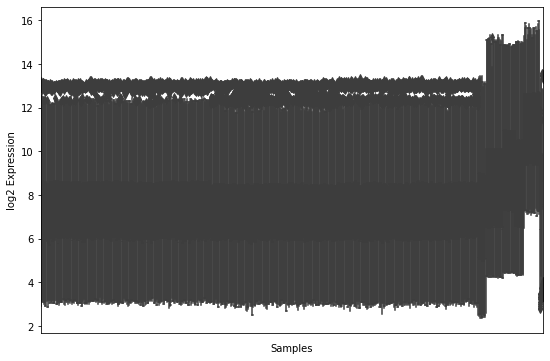

In [28]:
matplotlib.pyplot.figure(figsize=(9, 6))
g = sns.boxplot(data=ex_matrix.T, palette='tab10')
g.set(xticklabels=[])
g.tick_params(bottom=False)
g.set(xlabel='Samples', ylabel='log2 Expression')
matplotlib.pyplot.show()


above figure shows that data has not unique scale.

In [31]:
import numpy 
def quantile_normalization(df):
    
    "Quantile normalization consists on sorting, averaging and re-ordering."
    "For more information: https://cmdlinetips.com/2020/06/computing-quantile-normalization-in-python/"
  
    # step 1/3: sorting sample values
    df_sorted = pd.DataFrame(numpy.sort(df.values, axis=0), index=df.index, columns=df.columns)
    # step 2/3: averaging rank values across samples
    df_mean = df_sorted.mean(axis=1)
    df_mean.index = numpy.arange(1, len(df_mean) + 1)
    # step 3/3: re-ordering samples
    df.rank(method="min").astype(int)
    df_qn = df.rank(method="min").stack().astype(int).map(df_mean).unstack()

    return df_qn



In [32]:
%%time
expression_qn = quantile_normalization(ex_matrix.T)



CPU times: user 277 ms, sys: 32.5 ms, total: 310 ms
Wall time: 323 ms


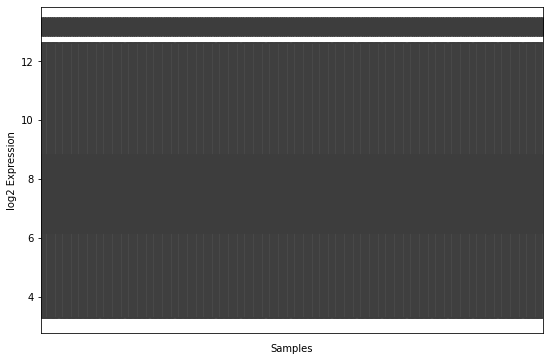

In [33]:
matplotlib.pyplot.figure(figsize=(9, 6))
g = sns.boxplot(data=expression_qn, palette='tab10')
g.set(xticklabels=[])
g.tick_params(bottom=False)
g.set(xlabel='Samples', ylabel='log2 Expression')
matplotlib.pyplot.show()

In [39]:
ex_matrix=expression_qn.T



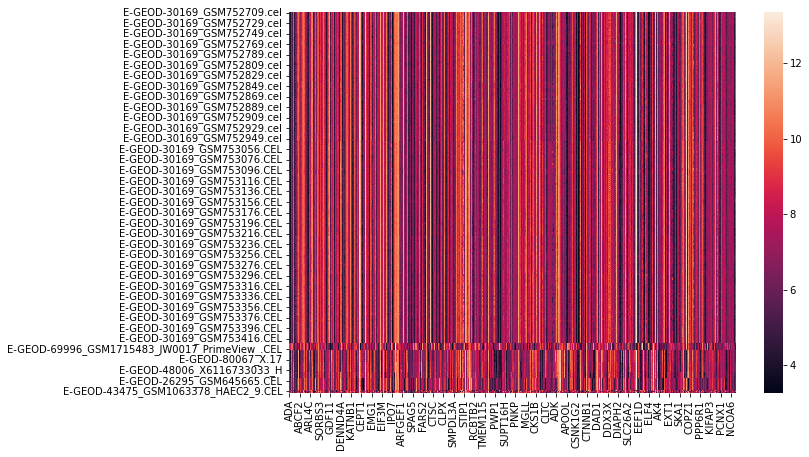

In [84]:
fig = matplotlib.pyplot.figure(figsize =(10, 7))
sns.heatmap(ex_matrix)
matplotlib.pyplot.show()

In [85]:
# the heatmap divided the gene experesions into 4 groups  

/Users/farhadzare/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/Users/farhadzare/opt/anaconda3/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


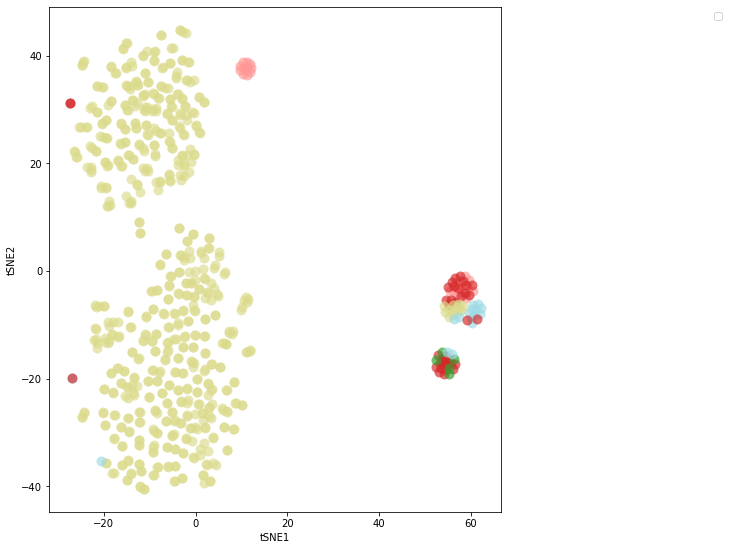

In [38]:
import sklearn, sklearn.manifold, sklearn.preprocessing


embedded = sklearn.manifold.TSNE(perplexity=45, init='pca', random_state=9).fit_transform(expression_qn.T)

matplotlib.pyplot.figure(figsize=(12, 8))
tagged_tissue = []

for i in range(len(embedded)):
    x = embedded[i, 0]
    y = embedded[i, 1]

    if tissue not in tagged_tissue:
        matplotlib.pyplot.plot(x, y, 'o', color=working_colors[i], alpha=2/3, ms=10, mew=0)
    else:
        matplotlib.pyplot.plot(x, y, 'o', color=working_colors[i], alpha=2/3, ms=10, mew=0)

matplotlib.pyplot.legend(bbox_to_anchor=(1.5, 1), ncol=2)
matplotlib.pyplot.xlabel('tSNE1')
matplotlib.pyplot.ylabel('tSNE2')
matplotlib.pyplot.tight_layout(pad=2)
#matplotlib.pyplot.savefig('figures/tsne.{}.pdf'.format(working_parameter))

In [40]:
DATA_FOLDER="/Users/farhadzare/Desktop/Thesis for master/Untitled Folder/tmp"
RESOURCES_FOLDER="/Users/farhadzare/Desktop/Thesis for master/Untitled Folder/resources"
DATABASE_FOLDER = "/Users/farhadzare/Desktop/Thesis for master/Untitled Folder/databases/"
homoData='/Users/farhadzare/Desktop/Thesis for master/Untitled Folder/databases/humans'
SCHEDULER="123.122.8.24:8786"
DATABASES_GLOB = os.path.join(homoData, "hg19-*.feather")

MOTIFS_HGNC_FNAME = os.path.join(RESOURCES_FOLDER, "motifs-v9-nr.hgnc-m0.001-o0.0.tbl")
MOTIF_ANNOTATIONS_FNAME = os.path.join(RESOURCES_FOLDER, "motifs-v9-nr.hgnc-m0.001-o0.0.tbl")
OUT_TFS_HGNC_FNAME = os.path.join(RESOURCES_FOLDER, 'hs_hgnc_tfs.txt')
MM_TFS_FNAME = os.path.join(RESOURCES_FOLDER , "mm_mgi_tfs.txt")
SC_EXP_FNAME = os.path.join(RESOURCES_FOLDER, "GSE60361_C1-3005-Expression.txt")
REGULONS_FNAME = os.path.join(DATA_FOLDER, "regulons.p")
MOTIFS_FNAME = os.path.join(DATA_FOLDER, "motifs.csv")


In [41]:
os.chdir("/Users/farhadzare/Desktop/Thesis for master/Untitled Folder")


In [42]:
ex_matrix.to_csv('OptimalwID.csv')


In [43]:
df_motifs_hgnc = pd.read_csv(MOTIFS_HGNC_FNAME, sep='\t')
hs_tfs = df_motifs_hgnc.gene_name.unique()
with open(OUT_TFS_HGNC_FNAME, 'wt') as f:
    f.write('\n'.join(hs_tfs) + '\n')
len(hs_tfs)

/var/folders/xw/ggml5mhd4n7315516lvx2p6c0000gn/T/ipykernel_53743/794328062.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_motifs_hgnc = pd.read_csv(MOTIFS_HGNC_FNAME, sep='\t')


1839

In [44]:

OUT_TFS_HGI_FNAME = os.path.join(RESOURCES_FOLDER, 'hs_hgnc_tfs.txt')



In [45]:
OUT_TFS_HGI_FNAME


'/Users/farhadzare/Desktop/Thesis for master/Untitled Folder/resources/hs_hgnc_tfs.txt'

In [46]:
df_motifs_Hgi = pd.read_csv(MOTIFS_HGNC_FNAME , sep='\t')



/var/folders/xw/ggml5mhd4n7315516lvx2p6c0000gn/T/ipykernel_53743/3311561502.py:1: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  df_motifs_Hgi = pd.read_csv(MOTIFS_HGNC_FNAME , sep='\t')


In [47]:
HO_tfs = df_motifs_Hgi.gene_name.unique()
len(HO_tfs)


1839

In [48]:
with open('/Users/farhadzare/Desktop/Thesis for master/Untitled Folder/resources/hs_hgnc_tfs.txt', 'wt') as f:
    f.write('\n'.join(HO_tfs) + '\n')  


In [49]:
tf_names = load_tf_names(OUT_TFS_HGNC_FNAME)


In [50]:
len(tf_names)


1839

In [51]:
def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3


In [52]:
adjancencies = grnboost2(expression_data=ex_matrix, tf_names=tf_names, verbose=True)


preparing dask client


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


parsing input
creating dask graph
4 partitions
computing dask graph
shutting down client and local cluster
finished


In [53]:
adjancencies.head()


,TF,target,importance
17,CEBPG,CEBPB,166.319556
17,CEBPB,MTHFD2,115.508885
17,CEBPB,CEBPG,114.497749
61,EEF1D,ETFB,101.649636
85,ZBTB1,LAMTOR5,99.380153


In [54]:
adjancencies.to_csv('ADJACENCIES.csv', index=False, sep='\t')
#adjacencies = pd.read_csv(ADJACENCIES_FNAME, sep='\t')


In [55]:
db_fnames = glob.glob(DATABASES_GLOB)
db_fnames

['/Users/farhadzare/Desktop/Thesis for master/Untitled Folder/databases/humans/hg19-tss-centered-10kb-10species.mc9nr.genes_vs_motifs.rankings.feather',
 '/Users/farhadzare/Desktop/Thesis for master/Untitled Folder/databases/humans/hg19-tss-centered-10kb-7species.mc9nr.genes_vs_motifs.rankings.feather',
 '/Users/farhadzare/Desktop/Thesis for master/Untitled Folder/databases/humans/hg19-500bp-upstream-7species.mc9nr.genes_vs_motifs.rankings.feather',
 '/Users/farhadzare/Desktop/Thesis for master/Untitled Folder/databases/humans/hg19-500bp-upstream-10species.mc9nr.genes_vs_motifs.rankings.feather',
 '/Users/farhadzare/Desktop/Thesis for master/Untitled Folder/databases/humans/hg19-tss-centered-5kb-10species.mc9nr.genes_vs_motifs.rankings.feather',
 '/Users/farhadzare/Desktop/Thesis for master/Untitled Folder/databases/humans/hg19-tss-centered-5kb-7species.mc9nr.genes_vs_motifs.rankings.feather']

In [56]:
def name(fname):
    return os.path.splitext(os.path.basename(fname))[0]

when it is needed

for i in db_fnames:
    convert_feather_v1_to_v2_vice_versa(i,i)

In [58]:
for i in db_fnames:
    print(name(i))

hg19-tss-centered-10kb-10species.mc9nr.genes_vs_motifs.rankings
hg19-tss-centered-10kb-7species.mc9nr.genes_vs_motifs.rankings
hg19-500bp-upstream-7species.mc9nr.genes_vs_motifs.rankings
hg19-500bp-upstream-10species.mc9nr.genes_vs_motifs.rankings
hg19-tss-centered-5kb-10species.mc9nr.genes_vs_motifs.rankings
hg19-tss-centered-5kb-7species.mc9nr.genes_vs_motifs.rankings


In [59]:
dbs = [RankingDatabase(fname=i, name=name(i)) for i in db_fnames]


In [60]:
dbs


[FeatherRankingDatabase(name="hg19-tss-centered-10kb-10species.mc9nr.genes_vs_motifs.rankings"),
 FeatherRankingDatabase(name="hg19-tss-centered-10kb-7species.mc9nr.genes_vs_motifs.rankings"),
 FeatherRankingDatabase(name="hg19-500bp-upstream-7species.mc9nr.genes_vs_motifs.rankings"),
 FeatherRankingDatabase(name="hg19-500bp-upstream-10species.mc9nr.genes_vs_motifs.rankings"),
 FeatherRankingDatabase(name="hg19-tss-centered-5kb-10species.mc9nr.genes_vs_motifs.rankings"),
 FeatherRankingDatabase(name="hg19-tss-centered-5kb-7species.mc9nr.genes_vs_motifs.rankings")]

In [61]:
modules = list(modules_from_adjacencies(adjancencies, ex_matrix))




2022-08-18 00:00:57,079 - pyscenic.utils - INFO - Calculating Pearson correlations.

2022-08-18 00:00:57,102 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2022-08-18 00:00:57,641 - pyscenic.utils - INFO - Creating modules.


In [67]:
print(len(modules))



512


In [63]:
Rank_module=[]
for i in range(len(modules)):
    Rank_module.append(len(modules[i]))
    

Text(0, 0.5, "frequency of modules' length")

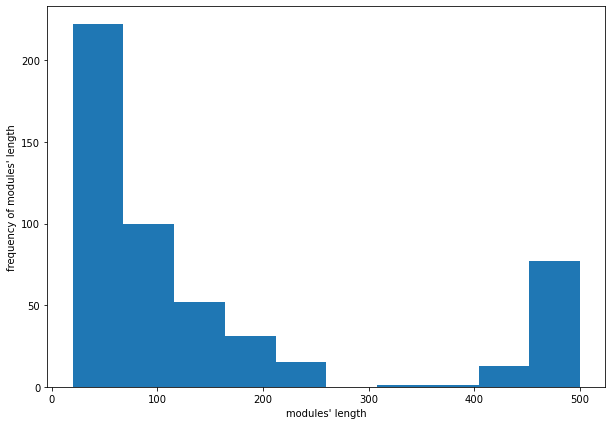

In [74]:
fig = matplotlib.pyplot.figure(figsize =(10, 7))
matplotlib.pyplot.hist(Rank_module)
matplotlib.pyplot.xlabel("modules' length")
matplotlib.pyplot.ylabel("frequency of modules' length")



In [69]:
# Calculate a list of enriched motifs and the corresponding target genes for all modules.
with ProgressBar():
    df = prune2df(dbs, modules, MOTIF_ANNOTATIONS_FNAME)

# Create regulons from this table of enriched motifs.
regulons = df2regulons(df)

[########################################] | 100% Completed |  5min 14.8s
Create regulons from a dataframe of enriched features.
Additional columns saved: []


In [70]:
len(regulons)



41

In [71]:
regulons[1].name



'ATF2(+)'

In [72]:
Rank_Regulons=[]
for i in range(len(regulons)):
    Rank_Regulons.append(len(regulons[i]))



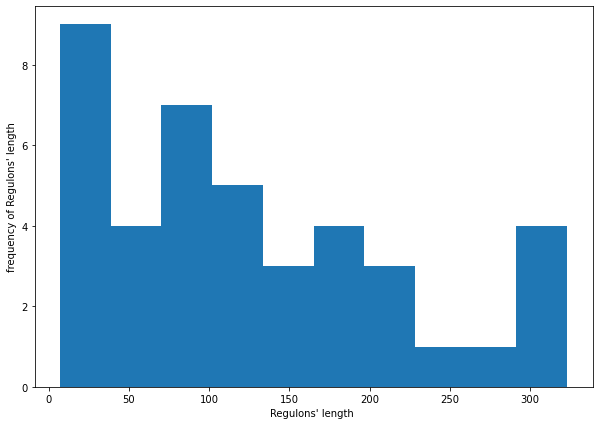

In [75]:
fig = matplotlib.pyplot.figure(figsize =(10, 7))
matplotlib.pyplot.hist(Rank_Regulons)
matplotlib.pyplot.xlabel("Regulons' length ")
matplotlib.pyplot.ylabel("frequency of Regulons' length")
matplotlib.pyplot.show()



In [76]:
# Save the enriched motifs and the discovered regulons to disk.
df.to_csv(MOTIFS_FNAME)
with open(REGULONS_FNAME, "wb") as f:
    pickle.dump(regulons, f)
    
    

In [77]:
df = load_motifs(MOTIFS_FNAME)
with open(REGULONS_FNAME, "rb") as f:
    regulons = pickle.load(f)
    
    

/Users/farhadzare/opt/anaconda3/lib/python3.9/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


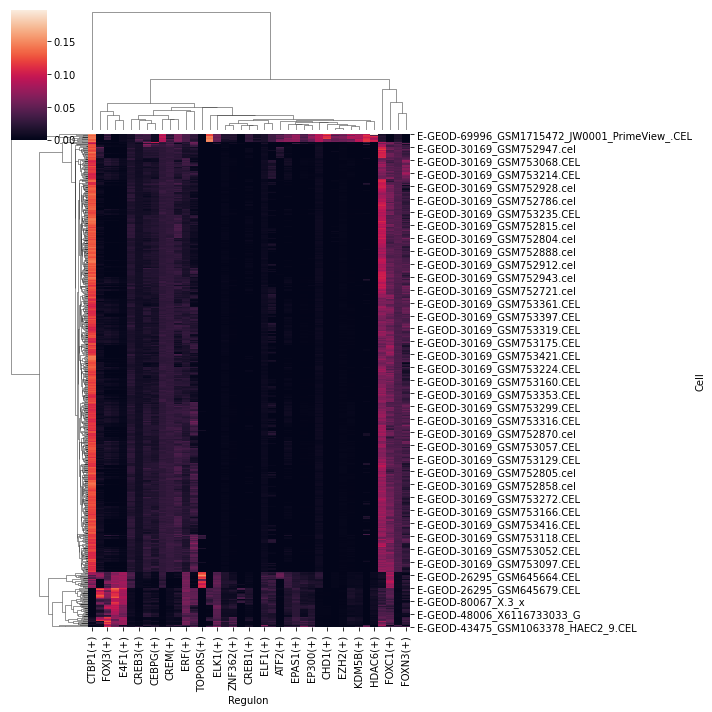

In [78]:
auc_mtx = aucell(ex_matrix, regulons, num_workers=5)
sns.clustermap(auc_mtx, figsize=(10,10))



As an example the regulon TOPORS(+) is active in the cells  E-GEOD-26295-GSM645664,-79 and inactive in the other cells.